In [8]:
# cil imports
from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData

from cil.processors import Slicer, AbsorptionTransmissionConverter, TransmissionAbsorptionConverter

from cil.optimisation.functions import IndicatorBox
from cil.optimisation.algorithms import CGLS, SIRT, CGLS
from cil.optimisation.utilities import callbacks
from cil.optimisation.operators import GradientOperator

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins import TomoPhantom

from cil.utilities import dataexample
from cil.utilities.display import show2D, show1D, show_geometry

# External imports
import numpy as np
import matplotlib.pyplot as plt
import logging

cmap = "gray"
device = 'gpu'

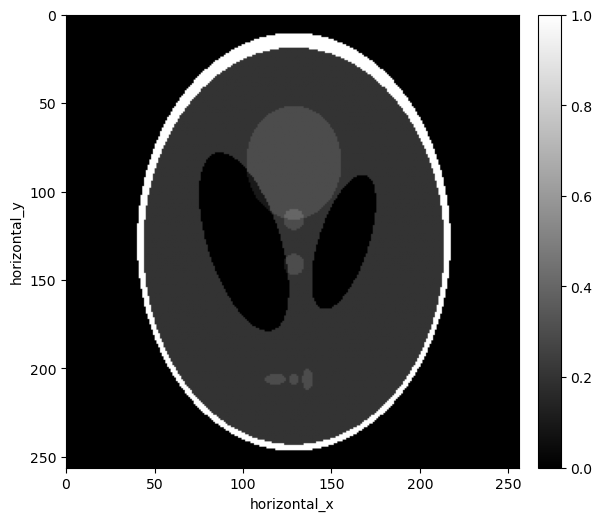

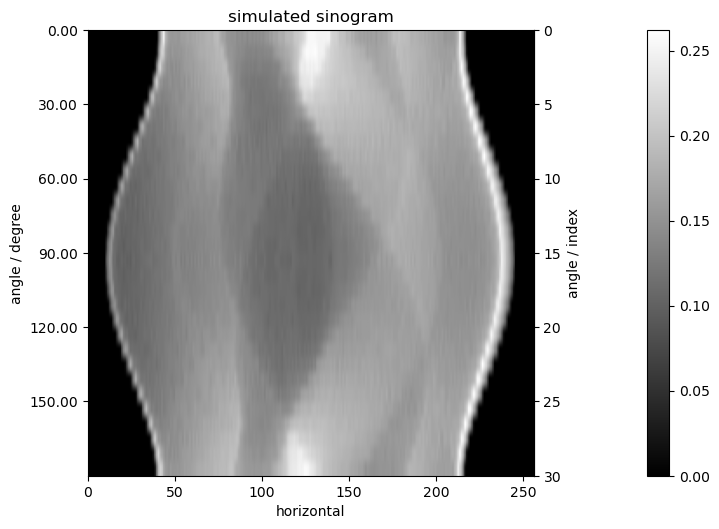

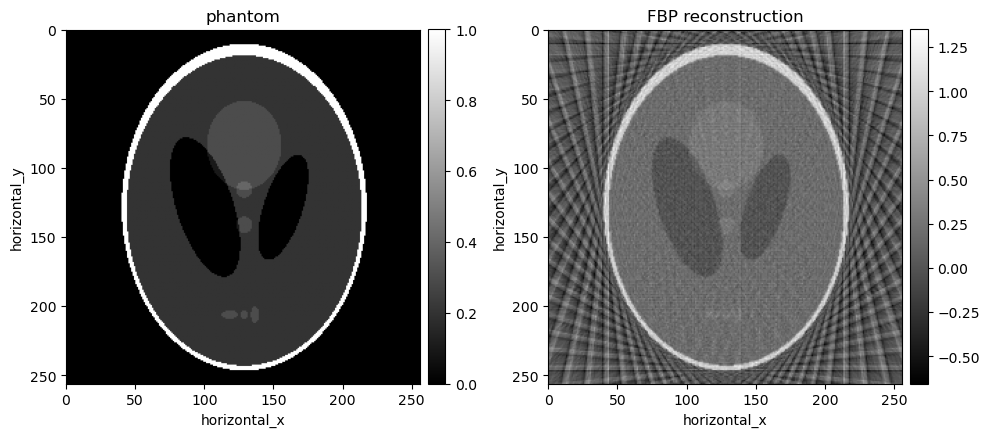

In [ ]:
# number of pixels
n_pixels = 256

# Angles
angles = np.linspace(0, 180, 30, endpoint=False, dtype=np.float32)


# Setup acquisition geometry
# with sufficient number of projections
ag = AcquisitionGeometry.create_Parallel2D()\
                            .set_angles(angles)\
                            .set_panel(n_pixels, pixel_size=1/n_pixels)

# Setup image geometry
ig = ImageGeometry(voxel_num_x=n_pixels, 
                   voxel_num_y=n_pixels, 
                   voxel_size_x=1/n_pixels, 
                   voxel_size_y=1/n_pixels)

# Get phantom
phantom = TomoPhantom.get_ImageData(num_model=1, geometry=ig)

# Visualise data
show2D(phantom, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')

# Create projection operator using Astra-Toolbox.
A = ProjectionOperator(ig, ag, device)

# Create an acquisition data (numerically)
sino = A.direct(phantom)

# Visualise data
show2D(sino, 'simulated sinogram', cmap=cmap, size=(10,10), origin='upper-left')

# reconstruct full data
# configure FBP
fbp = FBP(ig, ag, device)
# run on the AcquisitionData
recon_fbp = fbp(sino)

show2D([phantom, recon_fbp], ['phantom', 'FBP reconstruction'], \
G=       cmap=cmap, num_cols=2, size=(10,10), origin='upper-left')

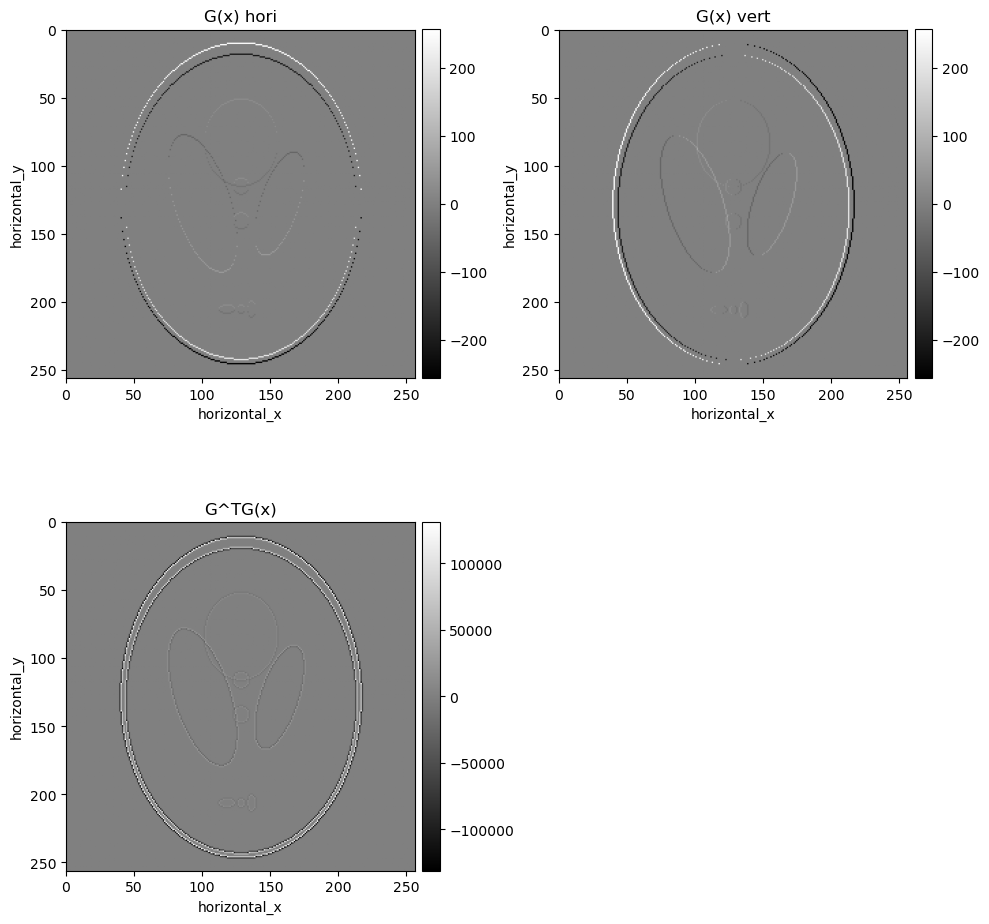

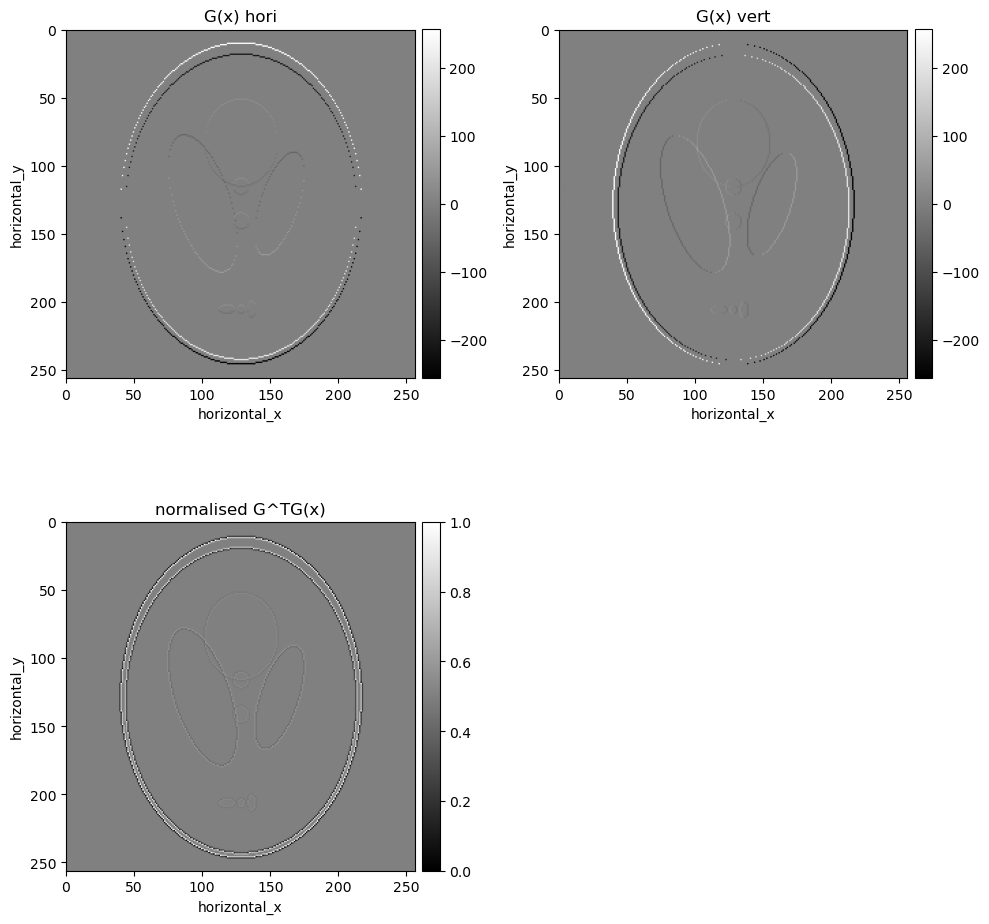

In [14]:
G = GradientOperator(ig)

show2D([G.direct(phantom)[0], G.direct(phantom)[1], G.adjoint(G.direct(phantom))], ['G(x) hori', 'G(x) vert' , 'G^TG(x)'], \
       cmap=cmap, num_cols=2, size=(10,10), origin='upper-left')

ish_recon= G.adjoint(G.direct(phantom))

norm_ish_recon= (ish_recon - np.min(ish_recon.as_array()))/ (np.max(ish_recon.as_array())-np.min(ish_recon.as_array()))

show2D([G.direct(phantom)[0], G.direct(phantom)[1], norm_ish_recon], ['G(x) hori', 'G(x) vert' , 'normalised G^TG(x)'], \
       cmap=cmap, num_cols=2, size=(10,10), origin='upper-left')


In [12]:
x =G.direct(phantom)
x.shape

(2, 1)